In [1]:
import os
import numpy as np
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from sklearn.cluster import KMeans


BASE_PATH = os.path.dirname(os.getcwd())

In [2]:
# Base de dados com IPCA para ajustes
ipca = pd.read_csv(f"{BASE_PATH}/data/ipca_year.csv")

É possível fazer um apanhado do preço do papel a partir deste [site](https://www.cepea.esalq.usp.br/br/categoria/florestal.aspx), contudo é um trabalho braçal reunir todas as informações necessárias.

In [3]:
# Carrega dataset com preços
dataset = pd.read_csv(f"{BASE_PATH}/data/hqs/datasets/volumes.csv", sep="\t")

# Remove as editoras internacionais
dataset = dataset[(dataset.publisher != "VIZ MEDIA LLC") & (dataset.publisher != "VIZ MEDIA")]

# Padroniza nome de editora que veio em formatos diferentes
def conv_publisher(name: str):
    if name in ["MYTHOS", "KAZÉ MANGA", "VIZ MEDIA", "VIZ MEDIA LLC", "CARLSEN VERLAG GMBH", "GOLLANCZ", "PIXEL"]:
        return "OUTROS"
    elif name == "EDITORA JBC":
        return "JBC"
    else:
        return name

dataset.publisher = dataset.publisher.apply(lambda x: conv_publisher(x))

# Padroniza o formato de capa
conv_format = {
    "CAIXAS E COLEÇÕES": "OUTROS",
    "CANOA, GRAMPEADO OU COSTURADO": "CAPA COMUM",
    "CAPA CLÁSSICA COM BLOCAGEM": "CAPA COMUM",
    "CAPA COMUM": "CAPA COMUM",
    "CAPA DURA": "CAPA DURA",
    "CAPA FLEXÍVEL": "CAPA COMUM",
    "CAPA MOLE": "CAPA COMUM",
    "CAPA REFORÇADA": "CAPA COMUM",
    "CAPÍTULOS AVULSOS": "OUTROS",
    "ENCADERNAÇÃO COM GRAMPOS": "OUTROS",
    "LIVRO (CAPA TANKOBON)": "CAPA COMUM",
    "LIVRO CARTONADO": "CAPA COMUM",
    "LIVRO COM BRINDE": "CAPA COMUM",
    "LIVRO DE BOLSO": "CAPA COMUM",
    "ACABAMENTO ESPECIAL": "CAPA COMUM",
    "AGENDA OU CALENDÁRIO" : "OUTROS",
    "ESTAMPADO": "CAPA COMUM",
}
dataset.format = dataset.format.apply(lambda x: conv_format[x])

# Faz a remoção de registros anômalos no sentido de quantidade de páginas,
# que normalmente representam anúncios de kits de volumes. Também remove
# registros com categoria "OUTROS", que são campos não identificados.
dataset = dataset.loc[(dataset.pages < 800)]\
    .loc[(dataset.format != "OUTROS")]\
    .loc[(dataset.publisher != "OUTROS")]

# Extrai o ano de lançamento
dataset["release_year"] = dataset.release_date.apply(lambda x: int(x.split("-")[0]))

# Remove anomalias de tamanho
dataset = dataset.loc[dataset["height"] < 60]

# Cria uma feature para representar a área da capa, utilizada na análise de grupos
dataset["cover_area"] = dataset.apply(lambda x: x.height * x.width, axis=1)

## Visão Geral

A Editora Panini, como esperado, lidera a quantidade de volumes lançados. De fato, trata-se de uma transnacional que detêm o monopólio das publicações DC, Marvel e Turma da Mônica no Brasil. Assim, as outras editoras competem com outros tipos de lançamentos, como mangás ou títulos nacionais menores.

Importante observar o conjunto formato e preço da Editora Pipoca e Nanquim. Podemos inferir que ela possui um direcionamento para edições de luxo, representadas pelo formato CAPA DURA. Este nicho de atuação também se reflete no preço mediano, que chega a ser aproximadamente 2,5 vezes o preço das outras editoras.

NewPop e JBC são editoras cujos preços ajustados deveriam de ser bem próximos, porém o preço atual está bem mais inflacionado para a Editora JBC. Esta observação é curiosa, uma vez que esta editora possui quase que o dobro de publicações anuais, o que poderia refletir em uma maior escala e a possibilidade de operar em preços de capa mais baratos.

Antes de finalizar, é necessário comentar da Conrad. Esta editora passou por problemas financeiros / administrativos, que gerou um período de pouca ou nenhuma publicação. Desta forma, esta editora precisará de mais atenção nas análise, então uma análise global produziria muitos desvios. Em um momento oportuno retornaremos para os dados desta editora.

Com esta abordagem geral, podemos destacar algumas informações:

1. Panini domina grande parte do mercado, praticando os menores preços e atuando próximo do preço ajustado pela inflação;
2. Pipoca e Nanquim possui uma abordagem nichada para coleções de luxo, com menor volume de lançamento e foco em públicos maior renda para consumir volumes cerca de 2,5 vezes mais caros que o praticado pelas suas concorrentes;
3. É preciso entender quais são as diferenças entre NewPop e JBC, que deveriam praticar preços próximos.

In [4]:
publisher_stats = []

for publisher in set(dataset.publisher.values):
    # Recupera dados da editora e joga todos os preços para o ano atual
    subset = dataset.loc[dataset["publisher"] == publisher]
    last_year = dataset["release_year"].max()
    prices = []

    # Define a função de correção de preço por inflação
    def adjust(price: float, year: int) -> float:
        for y in range(year, last_year):
            value = ipca.loc[ipca["year"] == y]["value"].values[0]
            price = price * (1 + value / 100)
        return price

    for i in range(0, len(subset)):
        # Acessa dados e verifica se o ano está na tabela de IPCA
        current_price = subset["full_price"].values[i]
        current_year = subset["release_year"].values[i]
        if current_year < ipca["year"].min() or current_year == last_year:
            continue

        # Faz a correção do valor, jogando o preço para o tempo atual
        prices.append(adjust(current_price, current_year))

    publisher_stats.append({
        "Editora": publisher,
        "Lançamentos": len(subset),
        "Lançamentos por Ano": int(len(subset) / len(set(subset["release_year"]))),
        "Principal Formato": subset["format"].mode()[0],
        "Altura Mediana": subset["height"].median(),
        "R$ Atual": subset.loc[subset["release_year"] == last_year]["full_price"].median(),
        "R$ Histórico*": round(np.median(prices), 2)
    })

publisher_stats = pd.DataFrame(publisher_stats).sort_values("Lançamentos por Ano", ascending=False)
publisher_stats

,Editora,Lançamentos,Lançamentos por Ano,Principal Formato,Altura Mediana,R$ Atual,R$ Histórico*
1,PANINI,6147,558,CAPA COMUM,22.40,39.90,38.85
2,JBC,1782,77,CAPA COMUM,20.32,42.90,36.42
3,NEWPOP,558,31,CAPA COMUM,18.60,39.90,35.99
0,PIPOCA E NANQUIM,114,14,CAPA DURA,27.30,109.90,99.49
4,CONRAD,273,10,CAPA COMUM,23.00,89.45,82.89


## Lançamentos por Ano

Após avaliar todos os dados disponíveis, uma próxima etapa é avaliar como estão alocados os lançamentos por ano. Como verificamos anteriormente, as editoras Pipoca e Nanquim possuem poucos lançamentos quando comparadas com as outras. Desta forma, para evitar poluição e distração, nos concentraremos nas três editoras com volume de lançamentos expressivos: Panini, JBC e NewPop.

Selecionando o intervalo de 10 anos, começaremos avaliando as publicações desde 2014. No geral, existe uma tendência de crescimento do volume das publicações, o que pode indicar um mercado com potencial ainda em exploração. Sobre o ano de 2020, a queda de publicações pode ser um dos impactos da pandemia de COVID, com elevações de preços do dólar e, por consequência, do preço de negociação do papel, principal insumo deste setor.

Estratificando por editora, fica claro o abismo entre Panini e as demais, chegando a quase 80% das publicações realizadas e disponíveis para venda. A Editora JBC chega a publicar quase 2 vezes mais que a NewPop anualmente. Com isso, seria ainda mais esperado uma precificação menor, que não foi observada na análise geral.

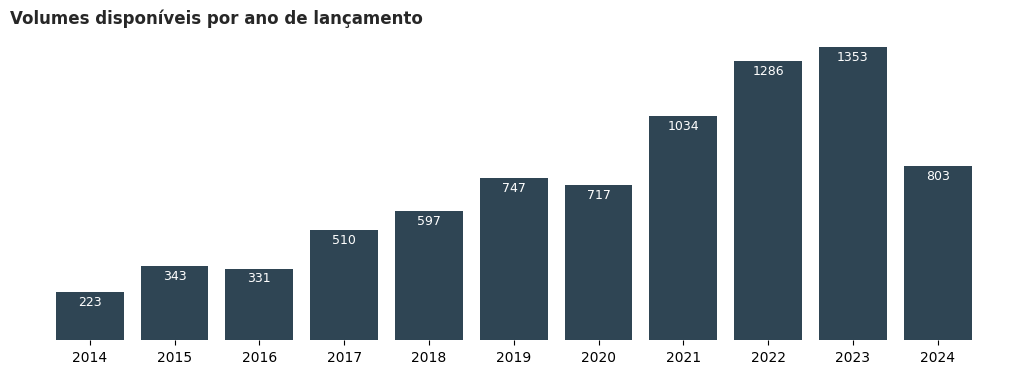

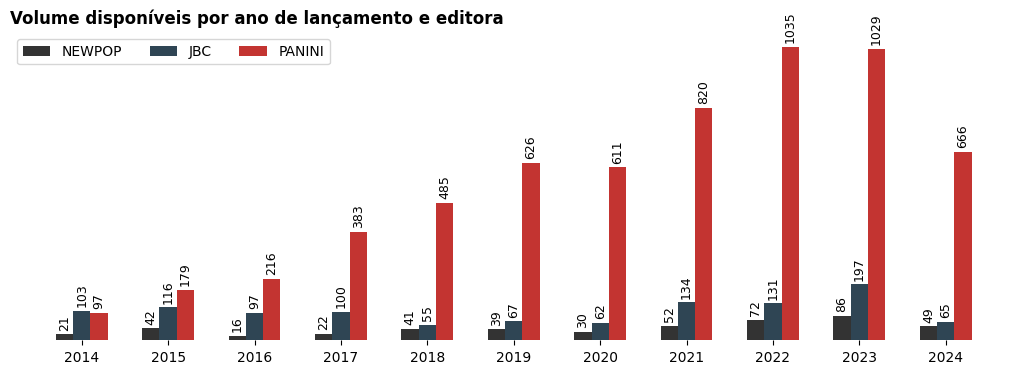

In [5]:
# Define o range de anos que serão avaliados
selected_years = list(range(2014, 2025))

# Calcula a quantidade de volumes disponíveis em cada ano
volumes_count = [list(dataset["release_year"]).count(y) for y in selected_years]

# Cria o gráfico com as configurações básicas
plt.figure(figsize=(13, 4))
ax = plt.subplot(111)
ax.set(frame_on=False)

ax.set_title("Volumes disponíveis por ano de lançamento", color="#272727", fontdict={"fontweight": 800}, loc="left")
ax.axes.get_yaxis().set_visible(False)
ax.set_xticks(selected_years)

# Configura as barras
ax.bar(selected_years, volumes_count, color="#2f4554")

# Método 1 para adicionar labels nas colunas
for rect, label in zip(ax.patches, volumes_count):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        height - 75,
        label,
        ha="center",
        va="bottom",
        fontsize=9,
        color="#fff"
    )
plt.show()

# Define as editoras, colres e tamanhos de colunas
publishers = ["NEWPOP", "JBC", "PANINI"]
colors = ["#333333", "#2f4554", "#c33431"]
volumes_count = []
width = 0.20

# Calcula os volumes disponíveis para cada editora
for publisher in publishers:
    subset = dataset.loc[(dataset.publisher == publisher)]
    volumes_count.append([list(subset.release_year).count(y) for y in selected_years])

# Configuração inicial do gráfico
plt.figure(figsize=(13, 4))
ax = plt.subplot(111)
ax.set(frame_on=False)

ax.set_title("Volume disponíveis por ano de lançamento e editora", fontdict={"fontweight": 800}, loc="left")
ax.axes.get_yaxis().set_visible(False)
ax.set_xticks(selected_years)

# Faz o desenho das barras para as editora
for i in range(0, len(volumes_count)):
    x = [s - width + i * width for s in selected_years]
    rect = ax.bar(x, volumes_count[i], width, label=publishers[i], color=colors[i])
    ax.bar_label(rect, padding=3, fontsize=9, rotation=90)

ax.legend(loc="upper left", ncols=len(publishers))
plt.show()

## Preços de Capa por Ano

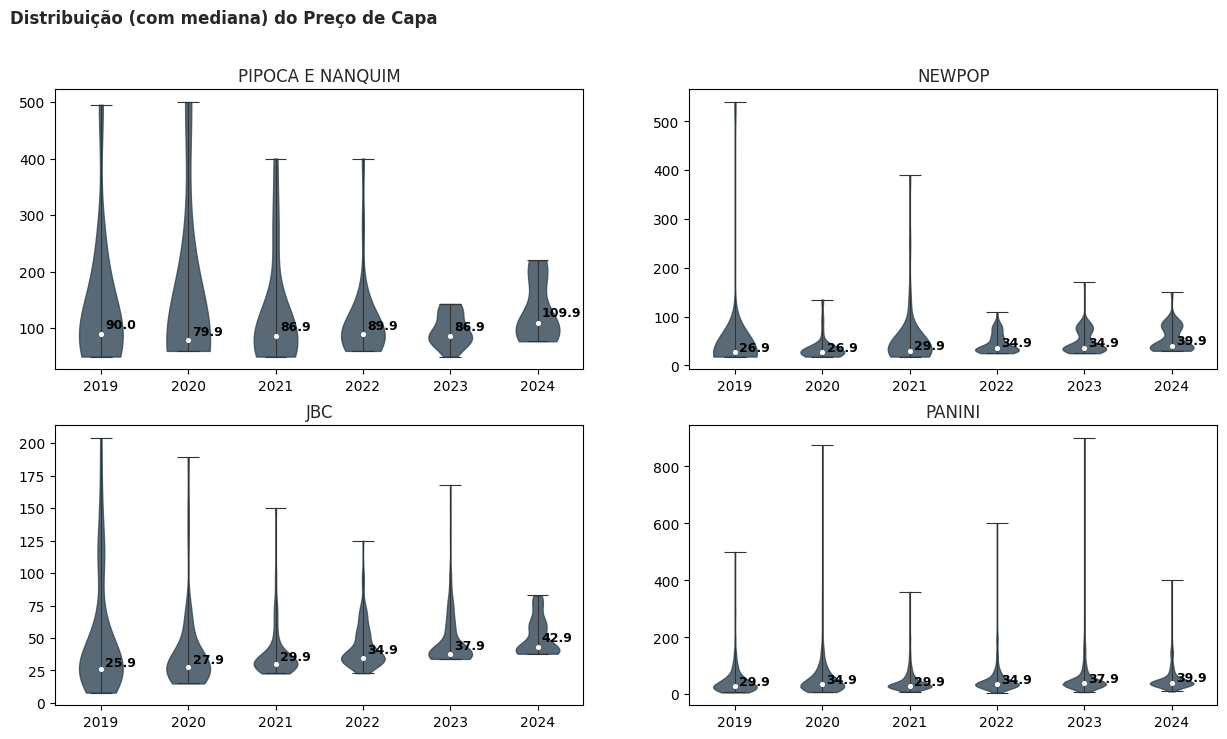

In [6]:
# Define o range de anos que serão avaliados
selected_years = list(range(2019, 2025))

# Cria a configuração básica dos gráficos
ax: List[List[Axes]]
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
fig.suptitle("Distribuição (com mediana) do Preço de Capa", color="#272727", weight=800, ha="left", x=0.095)

# Percorre as editoras
publishers = ["PIPOCA E NANQUIM", "NEWPOP", "JBC", "PANINI"]
axes = [ax[0][0], ax[0][1], ax[1][0], ax[1][1]]

for publisher, axs in zip(publishers, axes):
    # Filtra dados e recupera preços
    subset = dataset.loc[dataset.publisher == publisher]
    x = [subset.loc[subset.release_year == y]["full_price"].values for y in selected_years]
    medians = [np.percentile(x[i], 50) for i in range(0, len(x))]

    # Organiza o gráfico
    indices = [i + 1 for i in range(0, len(selected_years))]
    parts = axs.violinplot(x, showmedians=False, showextrema=True)
    axs.set_title(f"{publisher}", color="#272727")
    axs.set_xticks(indices, labels=selected_years)

    # Customização do corpo do violinplot
    for p in parts["bodies"]:
        p.set_color("#2f4554")
        p.set_alpha(0.8)

    # Customização dos elementos de estatística do violinplot
    for partname in ["cbars", "cmins", "cmaxes"]:
        parts[partname].set_edgecolor("#333333")
        parts[partname].set_linewidth(0.8)

    # Adição de itens descritivos
    axs.scatter(indices, medians, marker="o", color="white", s=7, zorder=3)
    for i in range(0, len(indices)):
        axs.text(indices[i] + 0.05, medians[i] * 1.1, medians[i], fontdict={"fontweight": 800, "fontsize": 9})

plt.show()

## Avaliação do Número de Páginas

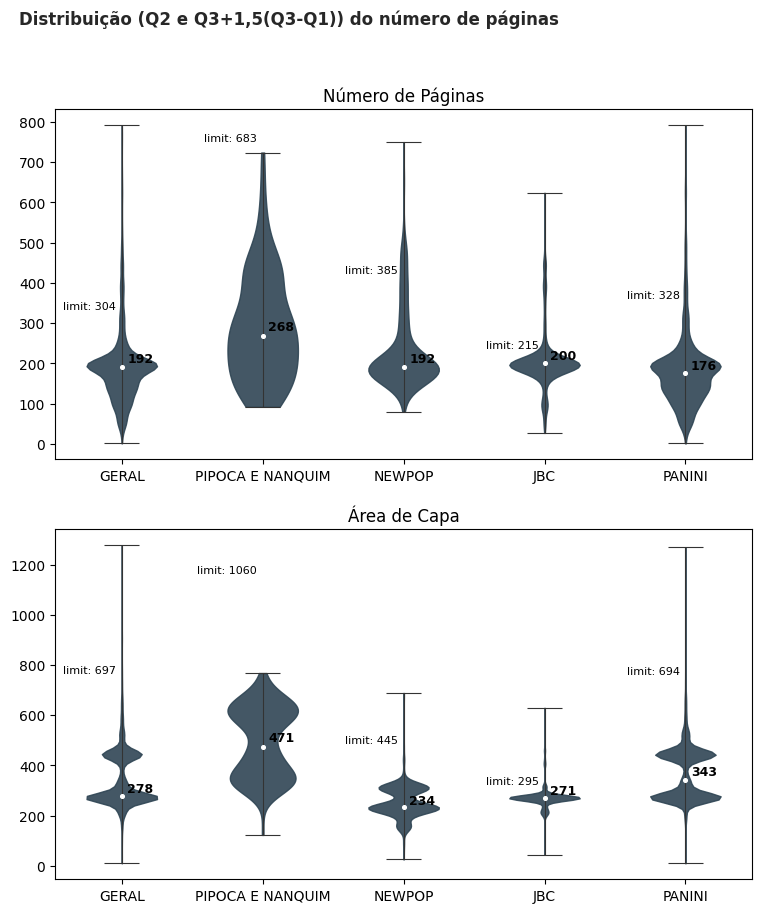

In [92]:
# Cria a configuração básica dos gráficos
ax: List[Axes]
fig, ax = plt.subplots(2, 1, figsize=(9, 10))
fig.suptitle("Distribuição (Q2 e Q3+1,5(Q3-Q1)) do número de páginas", color="#272727", weight=800, ha="left", x=0.085)

# Percorre variáveis
titles = ["Número de Páginas", "Área de Capa"]
columns = ["pages", "cover_area"]
axes = [ax[0], ax[1]]

for column, axs, title in zip(columns, axes, titles):
    # Para cada editora, seleciona as quantidades de páginas
    labels = ["GERAL"]
    x = [dataset[column].values]
    stats = np.percentile(x[-1], [25, 50, 75])
    medians = [stats[1]]
    max_limit = [stats[2] + 1.5 * (stats[2] - stats[0])]

    publishers = ["PIPOCA E NANQUIM", "NEWPOP", "JBC", "PANINI"]
    for publisher in publishers:
        x.append(dataset.loc[dataset["publisher"] == publisher][column].values)
        labels.append(publisher)

        stats = np.percentile(x[-1], [25, 50, 75])
        medians.append(stats[1])
        max_limit.append(stats[2] + 1.5 * (stats[2] - stats[0]))

    # Organiza o gráfico
    indices = [i + 1 for i in range(0, len(labels))]
    parts = axs.violinplot(x, showmedians=False, showextrema=True)
    axs.set_xticks(indices, labels=labels)
    axs.set_title(title)

    # Customização do corpo do violinplot
    for p in parts["bodies"]:
        p.set_color("#2F4554")
        p.set_alpha(0.9)

    # Customização dos elementos de estatística do violinplot
    for partname in ["cbars", "cmins", "cmaxes"]:
        parts[partname].set_edgecolor("#333333")
        parts[partname].set_linewidth(0.8)

    # Adição de itens descritivos
    axs.scatter(indices, medians, marker="o", color="white", s=7, zorder=3)
    for i in range(0, len(indices)):
        axs.text(indices[i] + 0.04, medians[i] * 1.05, int(medians[i]), fontdict={"fontweight": 800, "fontsize": 9})
        axs.text(indices[i] - 0.04, max_limit[i] * 1.1, f"limit: {int(max_limit[i])}", fontdict={"fontweight": 500, "fontsize": 8}, ha="right")

plt.show()

## Agrupamento de Formatos: Páginas e Dimensões

In [8]:
cluster_stats = []
cluster_range = [3, 4, 5]
variables_combination = [
    ["pages"],
    ["pages", "height", "width"],
    ["pages", "height"],
    ["pages", "width"],
    ["pages", "cover_area"]
]

def calculate_range(cluster_number: int):
    subset = dataset.loc[dataset["cluster"] == cluster_number]
    if len(subset) == 0:
        return "-"
    
    page_metrics = subset["pages"].quantile([0.25, 0.5, 0.75]).values
    height_metrics = subset["cover_area"].quantile([0.25, 0.5, 0.75]).values

    return (height_metrics[2] - height_metrics[0]) / height_metrics[1] + (page_metrics[2] - page_metrics[0]) / page_metrics[1]

for combination in variables_combination:
    for n_cluster in cluster_range:
        # Realiza o fit do agrupamento
        clustering = KMeans(n_clusters=n_cluster, init="k-means++")
        clustering.fit(dataset[combination].values)
        dataset["cluster"] = clustering.predict(dataset[combination].values)

        # Calcula métricas de desempenho
        metric = 0
        for i in range(0, n_cluster):
            metric = metric + calculate_range(i)

        cluster_stats.append({
            "Clusters": n_cluster,
            "Preditores": ", ".join(combination),
            "Distorção": metric
        })

cluster_stats = pd.DataFrame(cluster_stats).sort_values("Distorção", ascending=True)
cluster_stats

,Clusters,Preditores,Distorção
12,3,"pages, cover_area",1.491061
0,3,pages,1.718183
3,3,"pages, height, width",1.818682
6,3,"pages, height",1.867905
9,3,"pages, width",1.867905
1,4,pages,2.290113
13,4,"pages, cover_area",2.405081
14,5,"pages, cover_area",2.451005
7,4,"pages, height",2.705353
4,4,"pages, height, width",2.729865


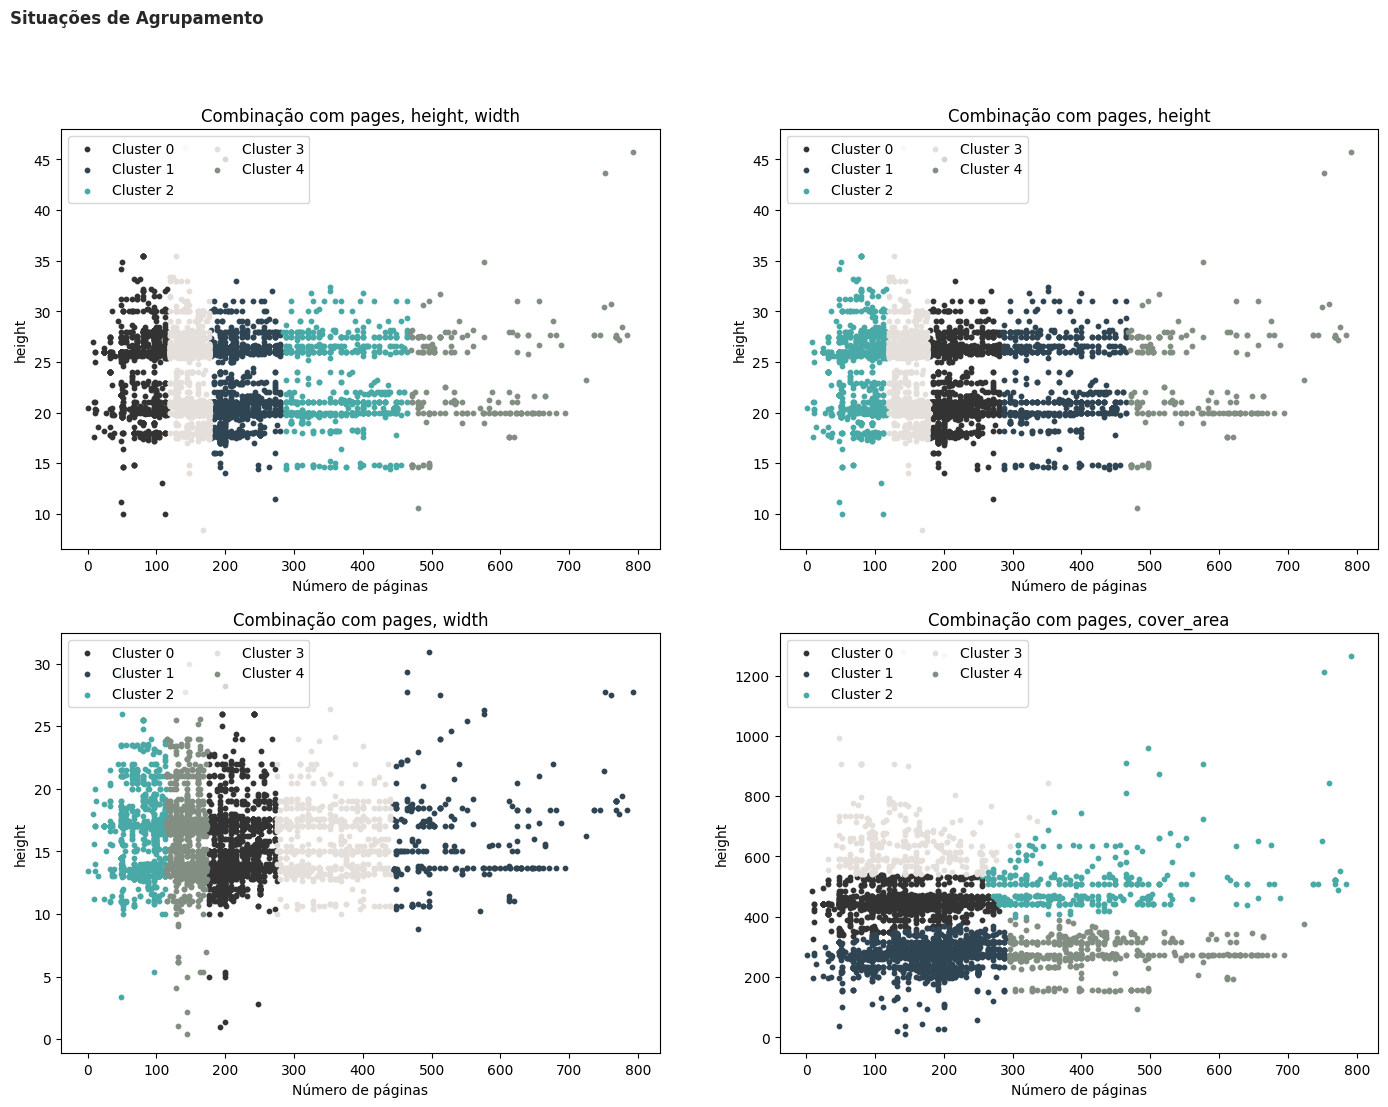

In [9]:
colors = ["#333333", "#2F4554", "#48A9A6", "#E4DFDA", "#838E83", "#D4B483"]
cluster_range = [2, 3, 4, 5]
variables_combination = [
    ["pages", "height", "width"],
    ["pages", "height"],
    ["pages", "width"],
    ["pages", "cover_area"],
    #["pages", "height", "width"]
]

# Cria a configuração básica dos gráficos
ax: List[List[Axes]]
fig, ax = plt.subplots(2, 2, figsize=(17, 12))
fig.suptitle("Situações de Agrupamento", color="#272727", weight=800, ha="left", x=0.095)
axes = [ax[0][0], ax[0][1], ax[1][0], ax[1][1]]

# Percorre as configurações
for j in range(0, len(variables_combination)):
    combination = variables_combination[j]
    axs = axes[j]

    n_clusters = 5
    clustering = KMeans(n_clusters=n_clusters, init="k-means++")

    clustering.fit(dataset[combination].values)
    columns = combination
    if len(columns) != 2:
        columns = ["pages", "height"]

    dataset["cluster"] = clustering.predict(dataset[combination].values)
    for i in range(0, n_clusters):
        subset = dataset.loc[dataset["cluster"] == i]
        x = subset[columns[0]].values
        y = subset[columns[1]].values

        axs.scatter(x, y, s=10, c=colors[i], label=f"Cluster {i}")        
        axs.set_xlabel("Número de páginas")
        axs.set_ylabel("height")
        axs.legend(loc="upper left", ncols=n_clusters // 2)
        axs.set_title(f"Combinação com {', '.join(combination)}")

plt.show()

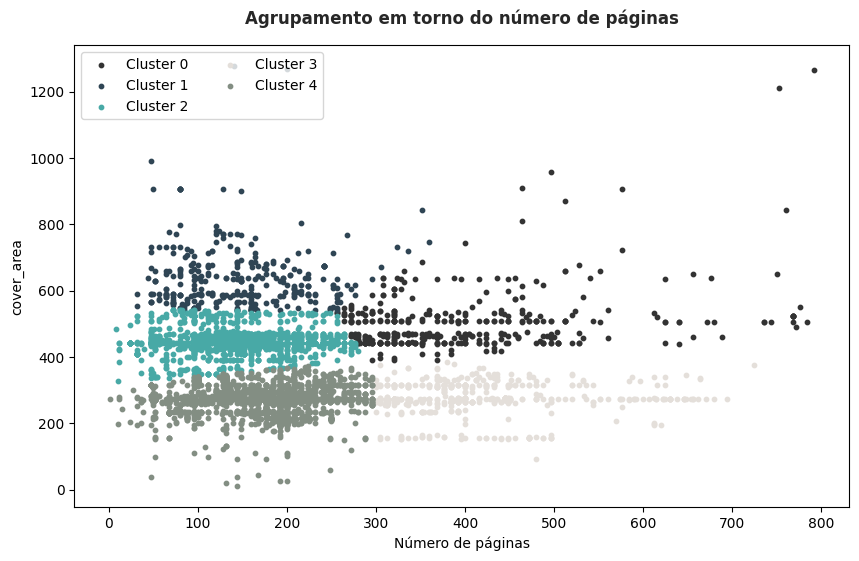

In [10]:
# Criação dos clusters
n_clusters = 5
columns = ["pages", "cover_area"]
colors = ["#333333", "#2F4554", "#48A9A6", "#E4DFDA", "#838E83", "#D4B483"]
clustering = KMeans(n_clusters=n_clusters, init="k-means++")

clustering.fit(dataset[columns].values)
dataset["len_cluster"] = clustering.predict(dataset[columns].values)

# Visualização gráfica dos dados
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)

for i in range(0, n_clusters):
    subset = dataset.loc[dataset.len_cluster == i]
    x = subset[columns[0]].values
    y = subset[columns[1]].values
    ax.scatter(x, y, s=10, c=colors[i], label=f"Cluster {i}")
    
    ax.set_xlabel("Número de páginas")
    ax.set_ylabel(columns[1])

ax.legend(loc="upper left", ncols=n_clusters // 2)
ax.set_title("Agrupamento em torno do número de páginas", color="#272727", fontdict={"fontweight": 800}, loc="center", pad=15)
plt.show()

In [11]:
dataset.head()

,format,download_at,full_price,name,publisher,release_date,pages,ISBN-10,ISBN-13,customers_review,about,height,width,depth,release_year,cover_area,cluster,len_cluster
0,CAPA COMUM,2024-04-15T15:02:47.382924,89.9,Calendar - Edição Especial,JBC,2023-08-9,448,6555944803,978-6555944808,4.0,Esta é uma estória de mudanças e crescimento e...,21.0,15.0,2.0,2023,315.0,4,3
1,CAPA COMUM,2024-04-09T11:36:51.351174,78.9,One Piece Vol. 1,PANINI,2024-05-20,192,8573516976,978-8573516975,4.8,A tripulação pirata mais famosa dos quadrinhos...,20.0,13.6,1.0,2024,272.0,1,4
2,CAPA COMUM,2024-04-15T15:02:57.405480,44.9,Quack! - Vol. 01,JBC,2023-08-9,192,6555944676,978-6555944679,8.0,O jovem Baltazar Drumont vem de uma família le...,21.0,15.0,1.0,2023,315.0,1,4
3,CAPA COMUM,2024-04-09T11:37:05.487100,36.9,Shangri-la Frontier - 02,PANINI,2024-05-20,200,6559604306,978-6559604302,4.9,"Sunraku decide encarar o jogo divino ""Shangri-...",20.0,13.7,1.5,2024,274.0,1,4
4,CAPA COMUM,2024-04-09T11:37:20.575021,36.9,Shangri-la Frontier Vol. 1,PANINI,2024-05-20,208,6559606872,978-6559606870,4.8,"Rakurou Hizutome, um rapaz apaixonado por ""jog...",20.0,13.7,1.8,2024,274.0,1,4


In [12]:
from statsmodels.multivariate.manova import MANOVA
fit = MANOVA.from_formula("publisher + pages + release_year + format ~ full_price", data=dataset)
print(fit.mv_test())

                                 Multivariate linear model
                                                                                            
--------------------------------------------------------------------------------------------
       Intercept               Value         Num DF   Den DF          F Value         Pr > F
--------------------------------------------------------------------------------------------
          Wilks' lambda               0.0000 8.0000 8865.0000 767777128781526784.0000 0.0000
         Pillai's trace               1.0000 8.0000 8865.0000 767777128781526784.0000 0.0000
 Hotelling-Lawley trace 692861481133921.5000 8.0000 8865.0000 767777128781526784.0000 0.0000
    Roy's greatest root 692861481133921.5000 8.0000 8865.0000 767777128781526784.0000 0.0000
--------------------------------------------------------------------------------------------
                                                                                            
-----------

In [13]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [14]:
def cluster_page(value: int):
    if value < 100:
        return "C1"
    elif value < 250:
        return "C2"
    elif value < 450:
        return "C3"
    else:
        return "C4"
dataset["pages_cluster"] = dataset.pages.apply(lambda x: cluster_page(x))

In [15]:
modelo = ols("full_price ~ C(publisher) + C(pages_cluster) + C(release_year) + C(publisher):C(pages_cluster):C(release_year)", data=dataset).fit()
anova_results = sm.stats.anova_lm(modelo, typ=3)
print(anova_results)

/media/bruno/Arquivos/Desenvolvimento/SomeAnalysis/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/media/bruno/Arquivos/Desenvolvimento/SomeAnalysis/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/media/bruno/Arquivos/Desenvolvimento/SomeAnalysis/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 28, but rank is 1
  warnings.warn('covariance of constraints does not have full '


                                                     sum_sq      df         F  \
Intercept                                      5.010480e+02     1.0  0.221603   
C(publisher)                                   2.004192e+03     4.0  0.221603   
C(pages_cluster)                               1.503144e+03     3.0  0.221603   
C(release_year)                                1.402934e+04    28.0  0.221603   
C(publisher):C(pages_cluster):C(release_year)  2.723831e+05   544.0  0.221451   
Residual                                       1.953742e+07  8641.0       NaN   

                                                 PR(>F)  
Intercept                                      0.637833  
C(publisher)                                   0.637833  
C(pages_cluster)                               0.637833  
C(release_year)                                0.637833  
C(publisher):C(pages_cluster):C(release_year)  0.637948  
Residual                                            NaN  


/media/bruno/Arquivos/Desenvolvimento/SomeAnalysis/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 544, but rank is 1
  warnings.warn('covariance of constraints does not have full '


In [16]:
anova_results

,sum_sq,df,F,PR(>F)
Intercept,5.010480e+02,1.0,0.221603,0.637833
C(publisher),2.004192e+03,4.0,0.221603,0.637833
C(pages_cluster),1.503144e+03,3.0,0.221603,0.637833
C(release_year),1.402934e+04,28.0,0.221603,0.637833
C(publisher):C(pages_cluster):C(release_year),2.723831e+05,544.0,0.221451,0.637948
Residual,1.953742e+07,8641.0,NaN,NaN


In [17]:
# Exibir um gráfico de barras com os preços médios por editora nos últimos 5 anos
# Exibir um gráfico de barras com a quantidade de lançamentos por editora nos últimos 5 anos

# Fazer teste anova para todas
# Fazer teste de média para cada par